# Churchland Widefield Data

This notebook demonstrates:
- Decoding L/R choice from different periods of the delay period

In [45]:
# Import statements
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from LVM import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [46]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

## 0. Specify the mouse and session date you are looking at

In [85]:
mouse = "mSM36"
day = "07-Dec-2017"
bn_version = 'version_4'

## 1A. Load data and BehaveNet reconstructions for the best model

In [86]:
def undo_zscore(neural, predictions):
    """
    Assumes data is trial x time x components
    
    Args:
        neural: original neural activity
        predictions: predicted z-scored activity
    Returns:
        predictions with the z-scoring undone
    """

    predictions = predictions.copy()
    predictions *= np.std(neural, axis=(0,1))
    predictions += np.mean(neural, axis=(0,1))
    return predictions

def zscore(data):
    """
    Assumes data is trial x time x components
    """

    data -= np.mean(data, axis=(0,1))
    data /= np.std(data, axis=(0,1))
    return data

In [87]:
# Load Session
session = Session("vistrained", mouse, day)
all_neural_data = session.neural['neural']
delay_period_indices = session.get_delay_period(include_stim=True)
excerpt_indices = []
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0] - 30
    end = delay_period_indices[trial,:][0] + 90
    excerpt_indices.append([start, end])
trial_choices = session.trialmarkers['ResponseSide']

In [88]:
# Load predictions
ffdatadir = "/home/chingf/Code/Widefield/analysis/musall/vistrained/" \
    + mouse + "/" + day + "/ae-neural/16_latents/ff/all/test/"
predictions_file = ffdatadir + bn_version + "/" + "predictions.pkl"
with open(predictions_file, "rb") as f:
    predictions_data = pickle.load(f)
predictions = np.nan_to_num(
    predictions_data['predictions']
    )
scaled_predictions = undo_zscore(all_neural_data, predictions)
predictions_trials = predictions_data['trials']

In [89]:
# Extract bins of interest
predictions_excerpt = []
neural_data_excerpt = []
for trial in range(scaled_predictions.shape[0]):
    activity = scaled_predictions[trial,:,:]
    indices = excerpt_indices[trial]
    predictions_excerpt.append(activity[indices[0]:indices[1],:])
    neural_data_excerpt.append(
        all_neural_data[trial,indices[0]:indices[1],:]
        )
scaled_predictions = np.array(predictions_excerpt)
neural_data_excerpt = np.array(neural_data_excerpt)

## 1B. Fit logistic regression models over each time step
### Features: flattened neural activity

In [85]:
def fit_LR(start_idx, window_length, data, trial_choices):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = data[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegressionCV(
        Cs=5, cv=5, scoring='accuracy', max_iter=500
        )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    log_reg.fit(X, y)
    return log_reg

In [86]:
# Reconstructions: Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
results = []

start_idxs = range(0, 120, 2)
for start_idx in start_idxs:
    log_reg = fit_LR(start_idx, window_length, scaled_predictions, trial_choices)
    results.append(log_reg)

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
# Save the logistic regression models
pickle.dump(results, open(
    "pickles/temporaldecoding_reconstructions_" + mouse + "_" + day + ".p", "wb"
    ))

## 2. Decoding: Which time periods are most predictive?
### Features: flattened neural activity

In [90]:
# Extract the results corresponding to window_size = 2
with open(
    "pickles/temporaldecoding_reconstructions_" + mouse + "_" + day + ".p", "rb"
    ) as f:
    results = pickle.load(f)

In [91]:
# Extract the results corresponding to window_size = 2
with open(
    "pickles/temporaldecoding_neural_" + mouse + "_" + day + ".p", "rb"
    ) as f:
    neur_results = pickle.load(f)

In [94]:
# Extract the results corresponding to window_size = 2
with open(
    "pickles/temporaldecoding_behavelatents_" + mouse + "_" + day + ".p", "rb"
    ) as f:
    bl_results = pickle.load(f)

In [95]:
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

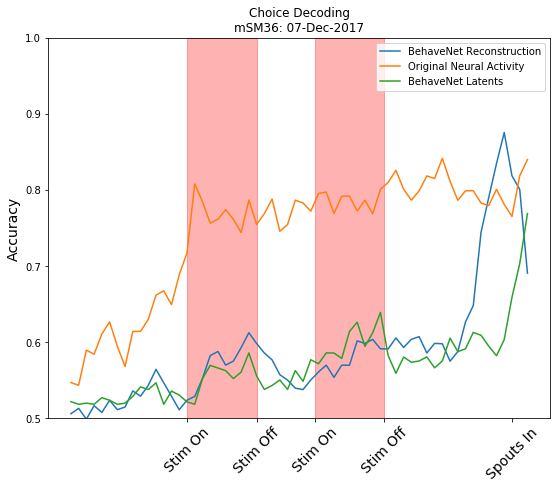

In [96]:
# Plot decoding accuracy over time
start_frame = []
accuracy = []
neur_accuracy = []
bl_accuracy = []
plt.figure(figsize=(9,7))
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
    
    # Do the same for behavenet latents
    bl_reg = bl_results[frame]
    bl_accuracy.append(
        np.max(np.mean(bl_reg.scores_[1], axis=0))
        )
    
    # Now do the same for the full neural data
    neur_log_reg = neur_results[frame]
    neur_accuracy.append(
        np.max(np.mean(neur_log_reg.scores_[1], axis=0))
        )
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding\n" + mouse + ": " + day)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim((0.5,1))
sns.lineplot(
    x=start_frame, y=accuracy, label="BehaveNet Reconstruction",
    linewidth=1.5
    )
sns.lineplot(
    x=start_frame, y=neur_accuracy, label="Original Neural Activity",
    linewidth=1.5
    )
sns.lineplot(
    x=start_frame, y=bl_accuracy, label="BehaveNet Latents",
    linewidth=1.5
    )

## 3. Decoding: Which regions are most predictive?
### Using window frames of length 2 frames

In [49]:
# Collect coefficient values
coef_values_df = {}
coef_values_df['Trial Event'] = []
coef_values_df['Coefficients'] = []
coef_values_df['Brain Region'] = []
frames = [14/2, 40/2, 56/2, 72/2, 90/2]
events = ['Pre-Stim', 'Stim 1', 'Between Stims', 'Stim 2', 'Delay']

# Iterate over each region
session = Session("vistrained", mouse, day, access_engram=False, load_behavenet=False)
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names
for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        # For each time step, collect the relevant coefficient values
        for idx, log_reg in enumerate(results):
            if idx not in frames:
                continue
            normalized_coefs = normalize(log_reg.coef_).squeeze()
            coef_values_df['Trial Event'].append(events[frames.index(idx)])
            coef_values_df['Coefficients'].append(
                np.abs(normalized_coefs[component-1]) # Components is 1-indexed!
                )
            coef_values_df['Brain Region'].append(reg_name)
coef_values_df = pd.DataFrame(data=coef_values_df)

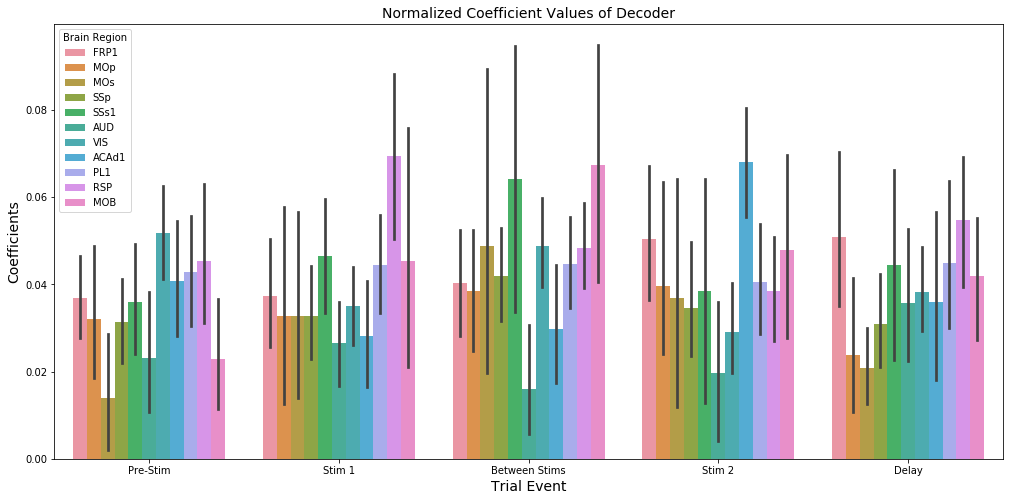

In [50]:
plt.figure(figsize=(17,8))
plt.title("Normalized Coefficient Values of Decoder", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.xlabel("Trial Event", fontsize=14)
ax = sns.barplot(
    x="Trial Event", y="Coefficients", hue="Brain Region", data=coef_values_df
    )

## 4. Which regions are reconstructed best?

In [83]:
session = Session("vistrained", mouse, day, access_engram=False, load_behavenet=False)
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

Text(0.5, 0, 'Brain Region')

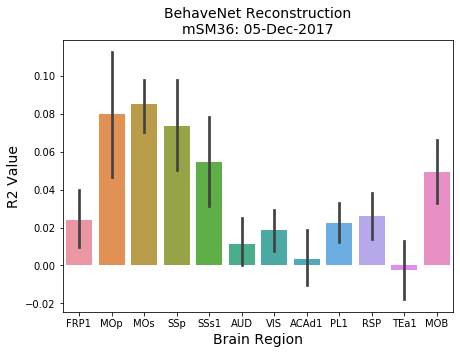

In [84]:
# Over the whole trial:
r2_df = {}
r2_df['R2 Value'] = []
r2_df['Brain Region'] = []
test_trials = predictions_trials['test']

for idx, reg_name in enumerate(reg_names):
    components = reg_indxs[idx].squeeze()

    # For each component in a region
    for component in components:
        pred_activity = scaled_predictions[test_trials,:,component-1]
        exp_activity = neural_data_excerpt[test_trials,:,component-1]
        r2 = r2_score(exp_activity, pred_activity)
        r2_df['Brain Region'].append(reg_name)
        r2_df['R2 Value'].append(r2)
r2_df = pd.DataFrame(data=r2_df)

plt.figure(figsize=(7,5))
plt.title("BehaveNet Reconstruction\n" + mouse + ": " + day, fontsize=14)
ax = sns.barplot(
    y="R2 Value", x="Brain Region", data=r2_df
    )
plt.ylabel("R2 Value", fontsize=14)
plt.xlabel("Brain Region", fontsize=14)

## 5. Trying a different classifier

In [8]:
# Import statements
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import warnings
scoring = ['accuracy']

In [9]:
def _gradientboosting_hyperparameter_search(X, y):
    """
        Returns the Gradient Boosting classifier using cross-validated
        optimal hyperparameters. Code adapted from:
        https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/
        Parameter_Tuning_GBM_with_Example/GBM%20model.ipynb
    """

    param_1 = {'n_estimators': np.linspace(20, 140, 10, dtype=int)}
    gsearch_1 = GridSearchCV(
        estimator=GradientBoostingClassifier(
            min_samples_split=max(int(y.size*.01), 2),
            max_depth=8,
            subsample=0.8
            ),
        param_grid=param_1,
        scoring='roc_auc',
        n_jobs=-1,
        iid=False,
        cv=5
        )
    gsearch_1.fit(X, y)
    opt_n_estimators = gsearch_1.best_params_['n_estimators']
    if opt_n_estimators == 20 or opt_n_estimators == 140:
        warnings.warn("n_estimators is at a boundary value: " + str(opt_n_estimators))

    param_2 = {
            'max_depth':np.linspace(3, 15, 5, dtype=int),
            'min_samples_split':np.linspace(20,500,5, dtype=int)
            }
    gsearch_2 = GridSearchCV(
        estimator=GradientBoostingClassifier(
            n_estimators=opt_n_estimators,
            subsample=0.8
            ),
        param_grid=param_2,
        scoring='roc_auc',
        n_jobs=-1,
        iid=False,
        cv=5
        )
    gsearch_2.fit(X, y)
    opt_max_depth = gsearch_2.best_params_['max_depth']
    opt_min_samples_split = gsearch_2.best_params_['min_samples_split']
    if opt_max_depth == 5 or opt_max_depth == 15:
        warnings.warn("max_depth is at a boundary value: " + str(opt_max_depth))
    if opt_min_samples_split == 20 or opt_min_samples_split == 500:
        warnings.warn("min_samples_split is at a boundary value: " +\
            str(opt_min_samples_split)
            )
    #import pdb;pdb.set_trace()

    param_3 = {'min_samples_leaf':np.linspace(20, 100, 10, dtype=int)}
    gsearch_3 = GridSearchCV(
        estimator=GradientBoostingClassifier(
            n_estimators=opt_n_estimators,
            max_depth=opt_max_depth,
            min_samples_split=opt_min_samples_split,
            subsample=0.8
            ),
        param_grid=param_3,
        scoring='roc_auc',
        n_jobs=-1,
        iid=False,
        cv=5
    )
    gsearch_3.fit(X, y)
    opt_min_samples_leaf = gsearch_3.best_params_['min_samples_leaf']
    if opt_min_samples_leaf == 20 or opt_min_samples_leaf == 100:
        warnings.warn("min_samples_leaf is at a boundary value: " +\
            str(opt_min_samples_leaf)
            )
    #import pdb;pdb.set_trace()

    param_4 = {'max_features': np.linspace(5, X.shape[1]//2, 10, dtype=int)}
    gsearch_4 = GridSearchCV(
        estimator=GradientBoostingClassifier(
            n_estimators=opt_n_estimators,
            max_depth=opt_max_depth,
            min_samples_split=opt_min_samples_split,
            min_samples_leaf=opt_min_samples_leaf,
            subsample=0.9
            ),
        param_grid=param_4,
        scoring='roc_auc',
        n_jobs=-1,
        iid=False,
        cv=5
    )
    gsearch_4.fit(X, y)
    opt_max_features = gsearch_4.best_params_['max_features']
    if opt_max_features == 5 or opt_max_features == X.shape[1]//2:
        warnings.warn("max_features is at a boundary value: " +\
            str(opt_max_features)
            )
    #import pdb;pdb.set_trace()

    param_5 = {'subsample': np.linspace(0.6, 1.0, 6)}
    gsearch_5 = GridSearchCV(
        estimator=GradientBoostingClassifier(
            n_estimators=opt_n_estimators,
            max_depth=opt_max_depth,
            min_samples_split=opt_min_samples_split,
            min_samples_leaf=opt_min_samples_leaf,
            max_features=opt_max_features
            ),
        param_grid=param_5,
        scoring='roc_auc',
        n_jobs=-1,
        iid=False,
        cv=5
    )
    gsearch_5.fit(X, y)
    opt_subsample=gsearch_5.best_params_['subsample']
    if opt_subsample == 0.6 or opt_subsample==1.0:
        warnings.warn("subsample is at a boundary value: " + str(opt_subsample))
    #import pdb;pdb.set_trace()

    return GradientBoostingClassifier(
        n_estimators=opt_n_estimators,
        max_depth=opt_max_depth,
        min_samples_split=opt_min_samples_split,
        min_samples_leaf=opt_min_samples_leaf,
        max_features=opt_max_features,
        subsample=opt_subsample
        )

In [10]:
def _evaluate_cv(model, X, y):
    """
        Gets the cross-validated roc_auc and accuracy score of some classifier.
        Additionally returns the best model over the cross-validation.
    """

    scores = cross_validate(
        model, X, y, scoring=scoring,
        cv=5, n_jobs=-1, return_estimator=True
        )
    test_scores = []
    for s in scoring:
        score_key = "test_" + s
        test_scores.append(scores[score_key])
    all_estimators = scores['estimator']
    best_estimator = all_estimators[np.argmax(scores["test_accuracy"])]
    return test_scores, best_estimator 

def _display_scores(scores):
    """
        Prints the mean and standard deviation of accuracy scores obtained
        through cross-validated classifiers.
    """

    for i in range(len(scores)):
        print("Using score: " + scoring[i])
        print("Mean: ", np.mean(scores[i]))
        print("Std Dev: ", np.std(scores[i]))
        print()

In [11]:
def run_gradientboosting(data, trial_choices):
    """
        Prints the result of training gradient tree boosting classifiers.
        Returns the fitted model.
    """

    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = data[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    gbrt = _gradientboosting_hyperparameter_search(X, y)
    scores, fitted_model = _evaluate_cv(gbrt, X, y)
    _display_scores(scores)
    return scores, fitted_model

In [12]:
# Reconstructions: Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
results = []
scores = []

start_idxs = range(0, 120, 2)
for start_idx in start_idxs:
    score, gb_model = run_gradientboosting(scaled_predictions, trial_choices)
    scores.append(score)
    results.append(gb_model)

/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100


Using score: accuracy
Mean:  0.5332212885154062
Std Dev:  0.05604169135945984



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 242


Using score: accuracy
Mean:  0.5355742296918768
Std Dev:  0.05516742543305749



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5284033613445379
Std Dev:  0.04917816693130644



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.4955182072829132
Std Dev:  0.05795957515710357



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5095518207282914
Std Dev:  0.034594620025398794



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20


Using score: accuracy
Mean:  0.4859663865546218
Std Dev:  0.0557378205767087



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.5307843137254903
Std Dev:  0.02098736575041734



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5047058823529411
Std Dev:  0.04200771143388172



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5047338935574229
Std Dev:  0.04147838021846409



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.5355742296918767
Std Dev:  0.04351718894399719



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.5047899159663866
Std Dev:  0.042817066265715784



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.5308683473389355
Std Dev:  0.04602425872293453



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15


Using score: accuracy
Mean:  0.5285434173669469
Std Dev:  0.04534999299263504



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5617647058823529
Std Dev:  0.031303821277802436



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5119047619047619
Std Dev:  0.01874366142627836



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 242
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.5048739495798319
Std Dev:  0.059156745959786754

Using score: accuracy
Mean:  0.526218487394958
Std Dev:  0.04396379736934502

Using score: accuracy
Mean:  0.5642016806722688
Std Dev:  0.05072840732082999



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 20


Using score: accuracy
Mean:  0.561624649859944
Std Dev:  0.06397718631983328



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15


Using score: accuracy
Mean:  0.5261904761904763
Std Dev:  0.05460503943036119



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100


Using score: accuracy
Mean:  0.5522128851540616
Std Dev:  0.06702370087091962



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.589971988795518
Std Dev:  0.04380737455952899



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 242


Using score: accuracy
Mean:  0.5854621848739496
Std Dev:  0.06728151375665067



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.5522128851540616
Std Dev:  0.04441824585432128



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5545098039215686
Std Dev:  0.07142381485782778



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15


Using score: accuracy
Mean:  0.5547058823529412
Std Dev:  0.06936795935532405



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.5499439775910364
Std Dev:  0.04736789924947682



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.545266106442577
Std Dev:  0.06863564805559033



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100


Using score: accuracy
Mean:  0.5499439775910364
Std Dev:  0.05294010936632966



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.566610644257703
Std Dev:  0.072407831208739

Using score: accuracy
Mean:  0.5379551820728292
Std Dev:  0.04782670162919496

Using score: accuracy
Mean:  0.5548459383753501
Std Dev:  0.07455131423052883



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.5903641456582633
Std Dev:  0.062072879693372995



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100


Using score: accuracy
Mean:  0.5547058823529412
Std Dev:  0.039037570694287045

Using score: accuracy
Mean:  0.559579831932773
Std Dev:  0.06256800237802447



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 242


Using score: accuracy
Mean:  0.5950700280112045
Std Dev:  0.055490570785353396



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140


Using score: accuracy
Mean:  0.5880112044817927
Std Dev:  0.059062513070638166



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5688795518207284
Std Dev:  0.03817120453375699



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.6068347338935574
Std Dev:  0.06087205326444807



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5618767507002802
Std Dev:  0.04890056774535617

Using score: accuracy
Mean:  0.5807843137254902
Std Dev:  0.04557048495476159



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5975070028011205
Std Dev:  0.06335118935279922



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.5878991596638656
Std Dev:  0.04912997579295564

Using score: accuracy
Mean:  0.6045098039215686
Std Dev:  0.04427776732017753



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5999999999999999
Std Dev:  0.08173437157717976



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 20


Using score: accuracy
Mean:  0.5809243697478992
Std Dev:  0.06438729821961588



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 242
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.5856302521008403
Std Dev:  0.061694167562758785

Using score: accuracy
Mean:  0.6094397759103641
Std Dev:  0.08412453531309

Using score: accuracy
Mean:  0.6046778711484594
Std Dev:  0.07353421886380596

Using score: accuracy
Mean:  0.6045658263305322
Std Dev:  0.05859469963850287

Using score: accuracy
Mean:  0.6094117647058823
Std Dev:  0.07409429012190291



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.623641456582633
Std Dev:  0.07899832102812473



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 1.0


Using score: accuracy
Mean:  0.6450420168067227
Std Dev:  0.09352104326319689



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: min_samples_leaf is at a boundary value: 100


Using score: accuracy
Mean:  0.6638935574229692
Std Dev:  0.07615341411972858



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20


Using score: accuracy
Mean:  0.7089635854341736
Std Dev:  0.10072203611752076



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: n_estimators is at a boundary value: 140
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20
/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: max_features is at a boundary value: 5


Using score: accuracy
Mean:  0.7280112044817927
Std Dev:  0.11681525336790133



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: max_depth is at a boundary value: 15


Using score: accuracy
Mean:  0.7705882352941177
Std Dev:  0.08853667793899567



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20


Using score: accuracy
Mean:  0.7040336134453782
Std Dev:  0.04750137049747594



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: UserWarning: subsample is at a boundary value: 0.6


Using score: accuracy
Mean:  0.7277310924369749
Std Dev:  0.05324229277400802



/home/chingf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: min_samples_split is at a boundary value: 20


Using score: accuracy
Mean:  0.6185714285714285
Std Dev:  0.018492826636078426



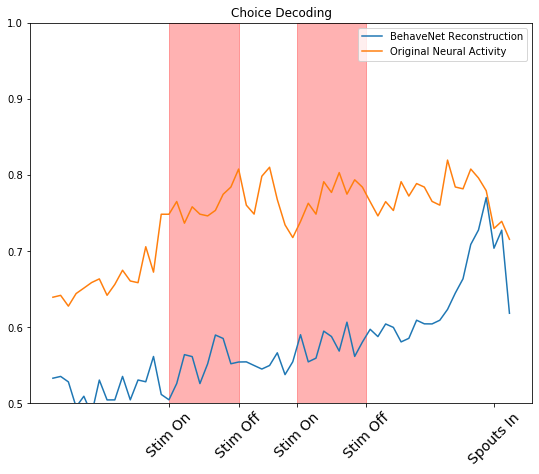

In [17]:
# Plot decoding accuracy over time
start_frame = []
accuracy = []
neur_accuracy = []
plt.figure(figsize=(9,7))
for frame, sc in enumerate(scores):
    start_frame.append(frame*2)
    accuracy.append(
        np.mean(sc)
        )
    
    # Now do the same for the full neural data
    neur_log_reg = neur_results[frame]
    neur_accuracy.append(
        np.max(np.mean(neur_log_reg.scores_[1], axis=0))
        )
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding")
plt.ylim((0.5,1))
sns.lineplot(
    x=start_frame, y=accuracy, label="BehaveNet Reconstruction",
    linewidth=1.5
    )
sns.lineplot(
    x=start_frame, y=neur_accuracy, label="Original Neural Activity",
    linewidth=1.5
    )